## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1.  compute the camera calibration using chessboard images

In [227]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

def get_calibration_mtx():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

### Computer camera calibration matrix

In [228]:
%matplotlib qt
mtx, dist = get_calibration_mtx()

## 2. use the calibration for new image testing  

In [229]:
%matplotlib inline
import numpy as np

def testimg_calibration(mtx, dist):
    images = glob.glob('../camera_cal/calibration*.jpg')
    testidx = np.random.randint(0, len(images))
    print('test on image file ', images[testidx])
    img = cv2.imread(images[testidx])

    dst = cv2.undistort(img, mtx, dist, None, mtx)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

test on image file  ../camera_cal\calibration5.jpg


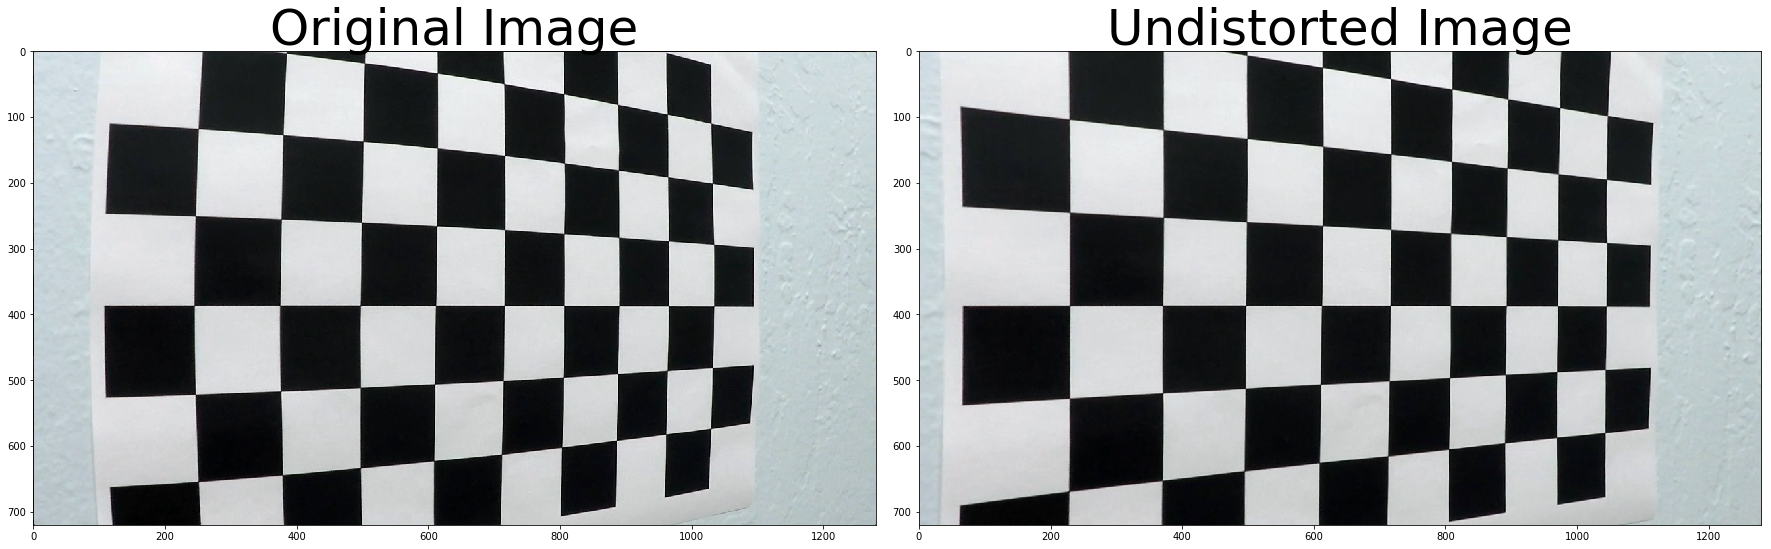

In [230]:
testimg_calibration(mtx, dist)


## 3 Apply a perspective transform to rectify binary image ("birds-eye view").
find a proper image to do the perspective transform


In [231]:
import os
%matplotlib inline
def get_perspective_transform_mtx():
    pers_img = os.path.join('..', 'test_images', 'straight_lines1.jpg')
    print(pers_img)
    img = cv2.imread(pers_img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    src = np.float32([[602, 444], [675, 444], [1050, 688], [253, 688]])
    dst = np.float32([[250, 0], [1050, 0], [1050, 700], [250, 700]])
    '''
          0   1
           ---
          /   \
         /     \
        /       \
        ---------
       3         2 
    '''
    plt.plot(*src[0], '.', color = 'r')
    plt.plot(*src[1], '.', color = 'r')
    plt.plot(*src[2], '.', color = 'r')
    plt.plot(*src[3], '.', color = 'r')
    plt.plot(*dst[0], 'x', color = 'y')
    plt.plot(*dst[1], 'x', color = 'y')
    plt.plot(*dst[2], 'x', color = 'y')
    plt.plot(*dst[3], 'x', color = 'y')

    # computer the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


..\test_images\straight_lines1.jpg


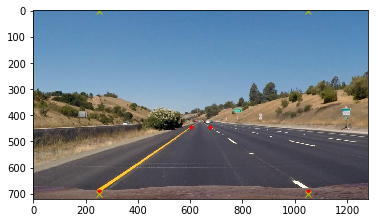

In [232]:
M, Minv = get_perspective_transform_mtx()

In [233]:
def testimg_perspective_transform(m):
    # do transformation on the test image
    # check the final warped image after perspective transformation
    imgname = os.path.join('..', 'test_images', 'straight_lines1.jpg')
    img = cv2.imread(imgname)    
    img_size = img.shape[1], img.shape[0]
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

In [ ]:
def get_perspective(m, img):
    shape = img.shape[1], img.shape[0]
    return cv2.warpPerspective(img, m, shape, flags = cv2.INTER_LINEAR)

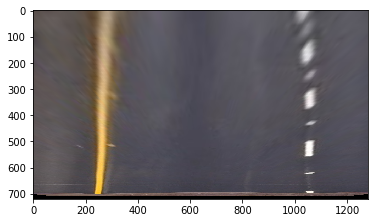

In [234]:
testimg_perspective_transform(M)   

## 4. Use color transforms, gradients, etc., to create a thresholded binary image.
define a function called bin img selection

In [235]:
from cv2 import Sobel

def build_binary_img(img, rawtype = 'bgr', orient = 'x', sobeltype = 's', s_thresh = (170, 255), sobel_thresh = (20, 100)):
    if rawtype == 'rgb': # cv2.imread()
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif rawtype == 'bgr': # matplotlib.image.imread()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    else:  # gray
        assert 0

    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    channel = gray
    sobelx = Sobel(channel, cv2.CV_64F, 1, 0)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255*sobelx/np.max(sobelx))
    
    sobely = Sobel(channel, cv2.CV_64F, 0, 1)
    sobely = np.absolute(sobely)
    sobely = np.uint8(255*sobely/np.max(sobely))

    # sobel_thresh = (20, 100)
    sobel_bin = np.zeros_like(sobelx)
    if orient == 'x':
        sobel_bin[(sobelx >= sobel_thresh[0]) & (sobelx <= sobel_thresh[1])] = 1
    else:
        sobel_bin[(sobely >= sobel_thresh[0]) & (sobely <= sobel_thresh[1])] = 1
        
    channel = S
    color_bin = np.zeros_like(channel)
    if orient == 'x':
        color_bin[(channel >= s_thresh[0]) & (channel <= s_thresh[1])] = 1
    else:
        color_bin[(channel >= s_thresh[0]) & (channel <= s_thresh[1])] = 1

    combined_bin = np.zeros_like(gray)
    combined_bin[(color_bin == 1) | (sobel_bin == 1)] = 1

#     sobel_bin = np.dstack(sobel_bin*3) *255
#     color_bin = np.dstack(color_bin*3) *255
#     combined_bin = np.dstack(combined_bin*3) *255
    
    return sobel_bin*255, color_bin*255, combined_bin*255

In [236]:

    
def testimg_build_binary():
    # test the function build_binary_image()
    images = glob.glob('../test_images/*.jpg')
    testidx = np.random.randint(0, len(images))
    print('testing the binary img build function on test image ', images[testidx])
    img = cv2.imread(images[testidx])

    img0 = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    img1, img2, img3 = build_binary_img(img0, rawtype = 'rgb' )

    f, ax = plt.subplots(2, 3, figsize=(48, 18))
    f.tight_layout()
    ax[0][0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0][0].set_title('Original Image', fontsize=32)
    
    ax[0][1].imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
    ax[0][1].set_title('perspective transformed img', fontsize=32)
    
    ax[0][2].imshow(img1, cmap = 'gray')
    ax[0][2].set_title('gray sobel x Image', fontsize=32)

    ax[1][0].imshow(img2, cmap = 'gray')
    ax[1][0].set_title('s color channel Image', fontsize=32)

    ax[1][1].imshow(img3, cmap = 'gray')
    ax[1][1].set_title('combin bin Image', fontsize=32)

    plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0, wspace=None, hspace=0.4)
    
    # img, img0 are color imgs
    # img1, img2, img3 are gray imgs
    return img, img0, img1, img2, img3

testing the binary img build function on test image  ../test_images\straight_lines2.jpg


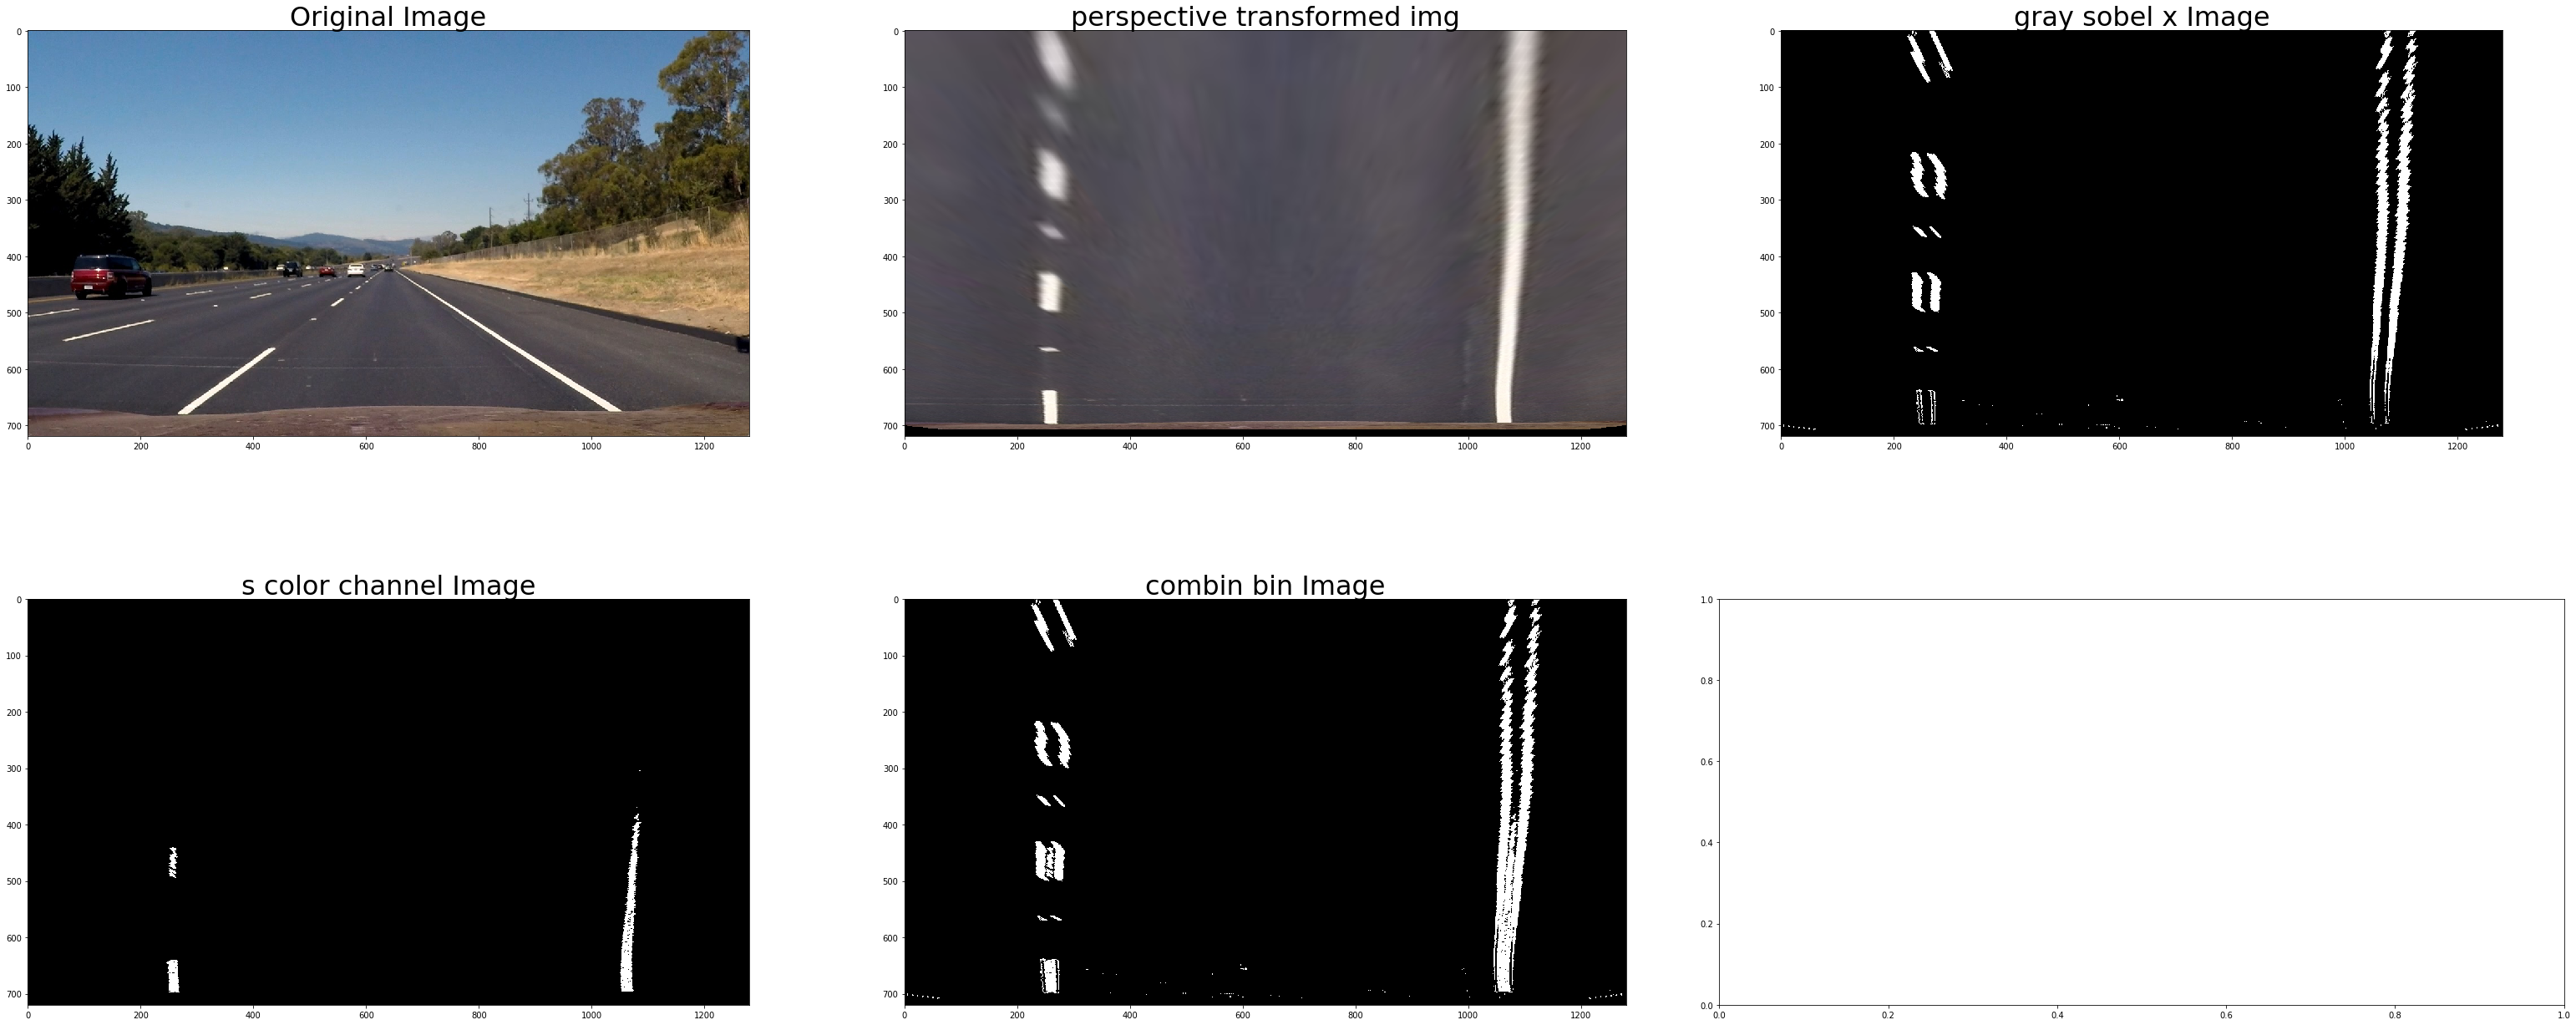

In [237]:
rawimg, img0, img1, img2, img3 = testimg_build_binary()

### 5. Detect lane pixels and fit to find the lane boundary.

In [238]:

def get_histogram(img):
    
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # as in the persepctive transformation, we have already changed the bottom half to the whole image,
    # then no need to only use the bottom half, just use the whole half
    histogram = np.sum(img[:,:], axis=0)
    out_img = np.dstack((img, img, img))
    plt.imshow(out_img)
    plt.show()
    plt.plot(histogram)
    plt.show()
    
    return histogram, out_img

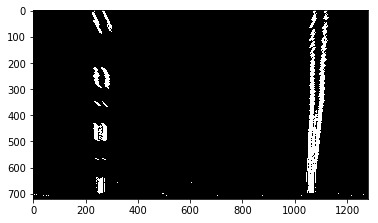

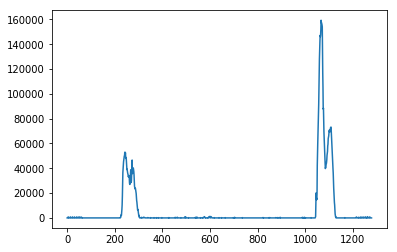

In [239]:
# img is the raw color img,
# img0 is the perspectived img
# img1 is the sobel x binary img
# img2 is the color threshold img
# img3 is the combination of img2 and img3

histogram, out_color = get_histogram(img3)

Sliding Window

In [240]:
# we use a class to collect all the variables together in a scope

# use it as global as it not changed [y_pixdels, x_pixels]
imgsize = img3.shape

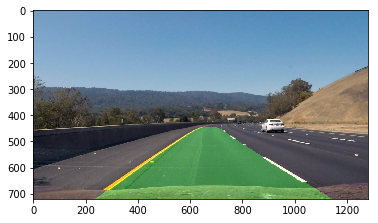

In [28]:
handler.drawBack()

In [ ]:
## merge them together

In [241]:
def get_sliding_windows_param():
    nwindows = 9
    window_height = np.int(imgsize[0]/nwindows)
    margin = 100
    minpix = 50
    return nwindows, window_height, margin, minpix

def get_sliding_windows_status(img, histogram):
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print('left base is: ', leftx_base, ' right base is: ', rightx_base)
    
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    print('non zero points in x: ', len(nonzerox), 'non zero points in y:', len(nonzeroy))
    leftx_current = leftx_base
    rightx_current = rightx_base
    return midpoint, leftx_current, rightx_current #, nonzerox, nonzeroy


In [242]:
def prepare_sliding_windows(img, histogram):
    # print(histogram.shape)
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print('left lane=', leftx_base, 'mid point=', midpoint, 'right lane=',rightx_base)
    # left side for the left lane detection, right side for the right lane detection

    # windows layer count
    nwindows = 9
    # window height
    window_height = np.int(img.shape[0]/nwindows)
    
    # collect the non zero pixels in the img
#     nonzero = img.nonzero()
#     nonzerox = np.array(nonzero[1])
#     nonzeroy = np.array(nonzero[0])
    print('nonzero pixels:', len(nonzerox))
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50

In [243]:
prepare_sliding_windows(img3, histogram)

left lane= 243 mid point= 640 right lane= 1067
nonzero pixels: 19442


In [280]:
left_lane_inds = []
right_lane_inds = []
print(nonzerox.shape)
print(nonzerox)
print(nonzeroy)

def sliding_windows(img, out_img):
    nwindows, window_height, margin, minpix = get_sliding_windows_param( )
    midpoint, leftx_current, rightx_current = get_sliding_windows_status(img, histogram)

    print(len(nonzerox), len(nonzeroy))
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 3) 
        cv2.rectangle(out_img, (win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) &(nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        # print('len good_left_inds is: ', len(good_left_inds))
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        # print('len good_right_inds is: ', len(good_right_inds))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    return out_img

(19442,)
[1006 1007 1008 ..., 1214 1215 1216]
[  0   0   0 ..., 708 708 708]


In [281]:
out_color = sliding_windows(img3, out_color)


left base is:  243  right base is:  1067
non zero points in x:  31737 non zero points in y: 31737
19442 19442


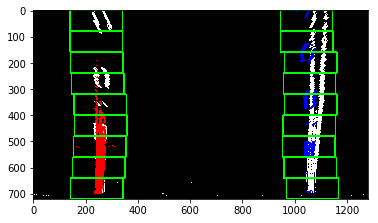

In [282]:
plt.imshow(out_color)

In [283]:
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

In [284]:
# Concatenate the arrays of indices
print(len(left_lane_inds))

print(len(left_lane_inds))
# Extract left and right line pixel positions
print('max in left lane inds is:', np.max(left_lane_inds))
print('nonzerox size is', nonzerox.shape)
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

11975
11975
max in left lane inds is: 19424
nonzerox size is (19442,)


visualization

(720, 0)

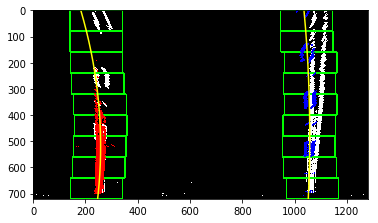

In [285]:
# Generate x and y values for plotting
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_color[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_color[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_color)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

skip the sliding window when we already know 

In [286]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!

#img3 is the new line
#left fit is the old fitting parameters
def nextFitting(newimg, oldfitting):
    left_fit, right_fit = oldfitting
    
    nonzero = newimg.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = (
        (nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
        (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = (
        (nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
        (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img3.shape[0]-1, img3.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fit, right_fit, left_fitx, right_fitx, ploty

visualize

(720, 0)

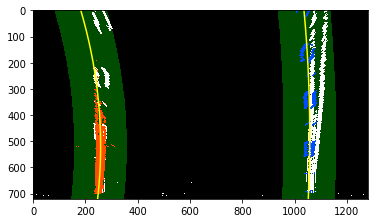

In [287]:
#  Create an image to draw on and an image to show the selection window
def output_fitting():
    out_img = np.dstack((img3, img3, img3))
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

### 6. Determine the curvature of the lane and vehicle position with respect to center.

sample 

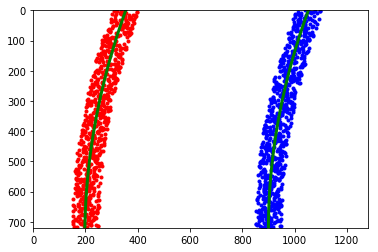

In [288]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [289]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

1807.46246398 1718.30514191


In [290]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

593.379543448 m 564.375620379 m


### 7. Warp the detected lane boundaries back onto the original image.

In [291]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [292]:
# Create an image to draw the lines on
def drawback(raw_img, warped):
    color_warp = np.zeros_like(warped).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (imgsize[1], imgsize[0]))
    plt.imshow(warped)
    plt.show()
    
    plt.imshow(newwarp)
    plt.show()
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    result = cv2.addWeighted(raw_img, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    plt.show()

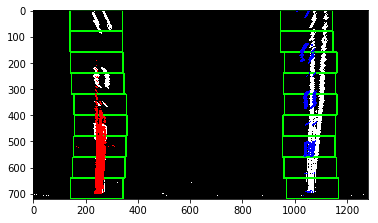

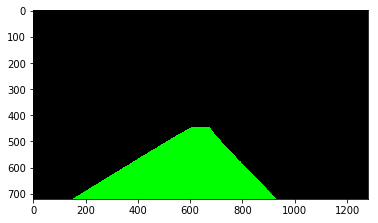

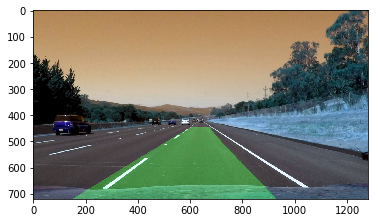

In [293]:
drawback(rawimg, out_color)

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 9. final pipe line function

In [31]:
# function for video handling
def process_image(img):
    perspective = get_perspective(M, img)
    return result        

../output_images\test1.jpg


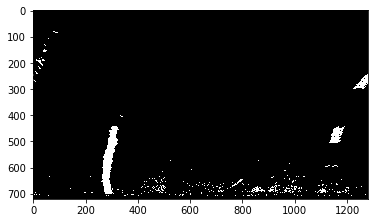

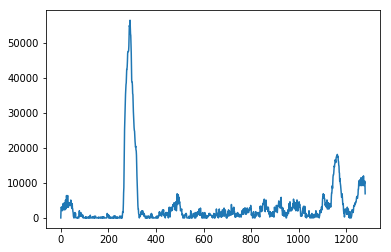

(720, 1280, 3)
(720, 1280)
(1280,)
left base is:  291  right base is:  1162
non zero points in x:  54615
starting class slidingWindow
left curvature is:  492.074513547  pixels, e.g,  152.684656868  meters
right curvature is:  549.038073786  pixels, e.g,  172.16909536  meters


TypeError: Image data can not convert to float

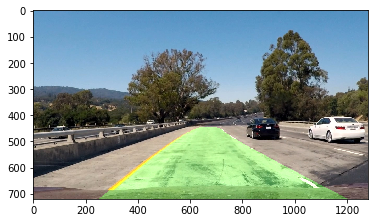

In [42]:
imgnames = glob.glob('../test_images/test*.jpg')
for imgname in imgnames:
    dirname, filename = os.path.split(imgname)
    newimgname = os.path.join('../output_images', filename)
    img = cv2.imread(imgname)
    result = process_image(img)
    plt.imshow(result)

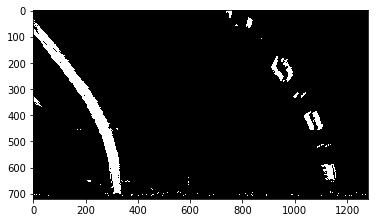

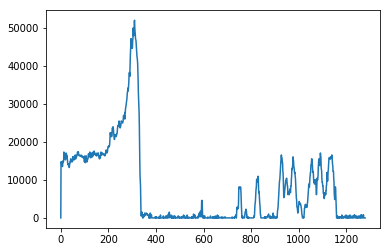

(720, 1280, 3)
(720, 1280)
(1280,)
left base is:  310  right base is:  1091
non zero points in x:  117168
starting class slidingWindow
left curvature is:  670.294186068  pixels, e.g,  220.151256973  meters
right curvature is:  805.843060784  pixels, e.g,  262.927406647  meters


AttributeError: 'NoneType' object has no attribute 'shape'

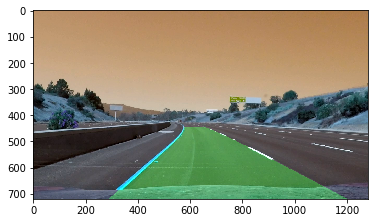

In [32]:
from moviepy.editor import VideoFileClip
video_input = '../project_video.mp4'
video_output = '../project_solution.mp4'
# challenge_output = 'test_videos_output/challenge.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip1 = VideoFileClip(video_input)
challenge_clip = clip1.fl_image(process_image)
%time challenge_clip.write_videofile(video_output, audio=False)